# IT-Skills for Research

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 20 16:18:28 2022

@author: angelDu @RB
"""
#%%
### Download necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import datetime 
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt 


# Specifying variables
path = r"C:\Users\angel\Final--crypto\data"
path= "/Users/julianfischer/projects/Final--crypto/data"


# Defining functions
def loadData(path):
    #cryptoPrices = pd.read_excel(path + '\CommonAssetClassesPrices.xlsx')
    equityPrices = pd.read_excel(path + '\Equities.xlsx')
    bondPrices = pd.read_excel(path + '\Bonds.xlsx')
    cmdtyPrices = pd.read_excel(path + '\Commodities.xlsx')
    vixPrices = pd.read_excel(path + '\VIX.xlsx')
    cryptoPrices = pd.read_excel(path + '\crypto-prices.xlsx')
    cryptoPrices['Dates'] = pd.to_datetime(cryptoPrices['Dates'])
    
    return equityPrices, bondPrices, cmdtyPrices, vixPrices, cryptoPrices

def loadData_forcoolguys(path):
    #cryptoPrices = pd.read_excel(path + '\CommonAssetClassesPrices.xlsx')
    equityPrices = pd.read_excel(path + '/Equities.xlsx')
    bondPrices = pd.read_excel(path + '/Bonds.xlsx')
    cmdtyPrices = pd.read_excel(path + '/Commodities.xlsx')
    vixPrices = pd.read_excel(path + '/VIX.xlsx')
    cryptoPrices = pd.read_excel(path + '/crypto-prices.xlsx')
    cryptoPrices['Dates'] = pd.to_datetime(cryptoPrices['Dates'])
    
    return equityPrices, bondPrices, cmdtyPrices, vixPrices, cryptoPrices

def getStartEnd(*data):
    minDate = datetime.datetime.strptime("30/11/0001","%d/%m/%Y")
    maxDate = datetime.datetime.strptime("30/11/3000","%d/%m/%Y")
    for d in data: 
        end = d['Dates'].iat[-1]
        start = d['Dates'][0]
        
        if end<maxDate:
            maxDate = end
            
        if start>minDate:
            minDate = start
            
    return minDate, maxDate
    
            
def makeDataUniformLength(start, end, assetList, *data):
    cnt = 0
    #aggData = []
    aggData = {}
    for d in data:
        d = d[(d['Dates']>=start)&(d['Dates']<=end)]
        #aggData.append([d])
        aggData[assetList[cnt]] = d
        cnt+=1
    
    return aggData

def mergeDataFrames(dictDf, assetList):
    merged = dictDf[assetList[0]]
    
    for i in range(len(assetList)):
        if i == len(assetList)-1:
            break
        merged = pd.merge(merged, dictDf[assetList[i+1]], on = ['Dates'])

    return merged 

def getBusinessDaysOnly(df):
    isBusinessDay = BDay().onOffset
    #isBusinessDay = BDay().is_on_offset()
    match_series = pd.to_datetime(df['Dates']).map(isBusinessDay)
    return df[match_series]

def calcDailyReturn(price):
    return price.pct_change(1)

def getCorr(df1,df2):
    corr, _ = pearsonr(df1, df2)
    return corr
    
    
#def plotRelationship(df1,df2):
# Importing data
assetNamesList = ['equity', 'bond', 'commodity', 'vix', 'crypto']
equity, bond, cmdty, vix, crypto = loadData_forcoolguys(path) 
#equity, bond, cmdty, vix, crypto = loadData(path) 
start, end = getStartEnd(equity, bond, cmdty, vix, crypto)
allData = makeDataUniformLength(start, end, assetNamesList, equity, bond, cmdty, vix, crypto)
mergedData = mergeDataFrames(allData, assetNamesList)

# Calculating returns
dailyRets = {}
for a in assetNamesList:
    dailyRets[a] = calcDailyReturn(allData[a].iloc[:,1:])

mergedDailyRets = calcDailyReturn(mergedData.iloc[:,1:])
mergedDailyRets.index = mergedData.Dates



In [7]:

Index_names = mergedData.columns



['equity', 'bond', 'commodity', 'vix', 'crypto']


Index(['Dates', 'Hang Seng', 'NASDAQ', 'Stoxx 50', 'Nikkei', 'S&P500', 'GILTS',
       'US 3m Treasury', 'US 5YR Treasury', 'US 10YR Treasury', 'Euro 10y',
       'Japan 10y', 'Corn', 'Wheat', 'Coffee', 'Soybean', 'Cotton', 'Gold',
       'Silver', 'Copper', 'Platinum', 'Crude', 'Nat. gas', 'Liver cattle',
       'VIX Index', 'BTC / USD Denominated Closing Price',
       'ETH / USD Denominated Closing Price',
       'XRP / USD Denominated Closing Price',
       'XLM / USD Denominated Closing Price'],
      dtype='object')

Table of p-values from the Granger Causality Test:
+---------------+-------+
| nasdaq_stoxx  | 0.034 |
| nasdaq_nikkei | 0.253 |
| vix_nasdaq    | 0.161 |
+---------------+-------+


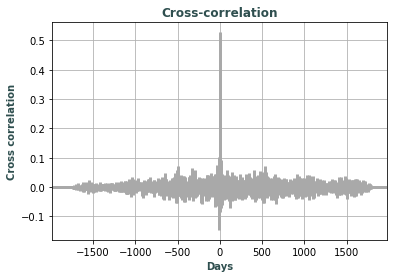

The maximal correlation is obtained 
  by shifting the index 0 days. (to the right if the number is positive.) 



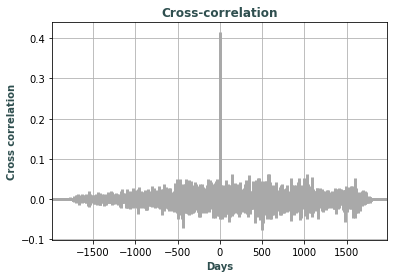

The maximal correlation is obtained 
  by shifting the index -1 days. (to the right if the number is positive.) 



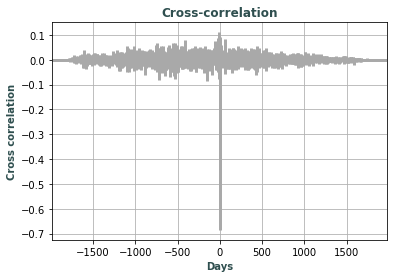

The maximal correlation is obtained 
  by shifting the index -8 days. (to the right if the number is positive.) 



In [34]:
from statsmodels.tsa.stattools import grangercausalitytests
from tabulate import tabulate
from scipy import signal

def get_grframe(grtest):
    #Returns a dataframe with the p-value of the ssr_chi2test
    grlist = []
    for i in range(1,maxlag):
        grlist.append(grtest[i][0]["ssr_chi2test"][1])
    grframe = pd.DataFrame(grlist, np.arange(1,maxlag), columns=['p-value'])
    grframe.index.name = "Number of lags"
    
    return grframe

maxlag= 30

df_nasdaq_stoxx = pd.DataFrame([mergedDailyRets["NASDAQ"],mergedDailyRets["Stoxx 50"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T
df_nasdaq_nikkei = pd.DataFrame([mergedDailyRets["NASDAQ"],mergedDailyRets["Nikkei"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T
df_vix_nasdaq = pd.DataFrame([mergedDailyRets["VIX Index"],mergedDailyRets["NASDAQ"]]).iloc[:,-mergedDailyRets.shape[0]+1:].T

gtest_nasdaq_stoxx = grangercausalitytests(df_nasdaq_stoxx, maxlag, verbose=False)
gtest_nasdaq_nikkei = grangercausalitytests(df_nasdaq_nikkei, maxlag, verbose=False)
gtest_vix_nasdaq = grangercausalitytests(df_vix_nasdaq, maxlag, verbose=False)



pvalues_gtest_nasdaq_stoxx = get_grframe(gtest_nasdaq_stoxx)
pvalues_gtest_nasdaq_nikkei = get_grframe(gtest_nasdaq_nikkei)
pvalues_gtest_vix_nasdaq = get_grframe(gtest_vix_nasdaq)

mean_pvalue_table = pd.DataFrame([np.mean(pvalues_gtest_nasdaq_stoxx),np.mean(pvalues_gtest_nasdaq_nikkei), np.mean(pvalues_gtest_vix_nasdaq)])
mean_pvalue_table.columns = ["Mean p-value"]
mean_pvalue_table.index = ["nasdaq_stoxx", "nasdaq_nikkei", "vix_nasdaq"]


print("Table of p-values from the Granger Causality Test:")
print(tabulate(round(mean_pvalue_table,3), tablefmt='psql'))

# the null hypothesis would be: X does not granger cause Y or the other way. Also, you accept or reject your null hypothesis depending on the level of significance.
# if P value < Significance level, then Null hypothesis would be rejected.
# if P value > Significance level, then Null hypothesis cannot be rejected.


def crosscorr_plot(data, a, col1, col2, new=False):
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    if new==True:
        ax1.xcorr(data[col1], data[col2], usevlines=True, maxlags=len(data[col1])-1,normed=True, lw=3, color="darkgrey")
        ax1.set_title("Cross-correlation",color="darkslategray",fontsize=12, fontweight="bold")
        temp = signal.correlate(data[col1], data[col2])
        shift = len(data[col1])-1

    else:
        
        ax1.xcorr(data[col1], data[col2], usevlines=True, maxlags=len(data[col1])-1,normed=True, lw=3, color="darkgrey")
        ax1.set_title("Cross-correlation",color="darkslategray",fontsize=12, fontweight="bold")
        temp = signal.correlate(data[col1], data[col2])
        shift = len(data[col1])-1

    ax1.grid(True)
    temp2 = int(np.where(temp == max(temp))[0])
    #or temp2 = np.argmax(temp)
    ax1.set_xlabel('Days',color="darkslategray",fontsize=10, fontweight="demi")
    ax1.set_ylabel('Cross correlation',color="darkslategray",fontsize=10, fontweight="demi")
    plt.show()
    print("The maximal correlation is obtained","\n"," by shifting the index",temp2-shift, "days. (to the right if the number is positive.)", "\n")
    return (temp2-shift)


lags_nasdaq_stoxx = crosscorr_plot(df_nasdaq_stoxx, 1, "NASDAQ", "Stoxx 50")
lags_nasdaq_nikkei = crosscorr_plot(df_nasdaq_nikkei, 1, "NASDAQ", "Nikkei")
lags_vix_nasdaq = crosscorr_plot(df_vix_nasdaq, 1, "VIX Index", "NASDAQ")



In [32]:
df_nasdaq_nikkei["Nikkei"]

Dates
2015-10-01    0.019224
2015-10-02    0.000153
2015-10-05    0.015817
2015-10-06    0.010031
2015-10-07    0.007527
                ...   
2022-11-14   -0.010618
2022-11-15    0.000955
2022-11-16    0.001362
2022-11-17   -0.003487
2022-11-18   -0.001103
Name: Nikkei, Length: 1802, dtype: float64

In [23]:
pvalues_gtest_nasdaq_stoxx

,p-value
Number of lags,
1,8.503245e-01
2,8.418334e-06
3,8.227941e-06
4,4.903002e-07
5,2.876007e-06
6,1.045384e-05
7,1.356725e-05
8,5.539538e-04
9,1.799361e-03


In [ ]:
""" Granger: start """



gtest_nasdaq_stoxx = grangercausalitytests(pd.DataFrame(mergedDailyRets["NASDAQ"],mergedDailyRets["Stoxx 50"]), maxlag, verbose=False)
gtest_new_ger = grangercausalitytests(ger_both_start_new_switched, maxlag, verbose=False)
gtest_new_chn = grangercausalitytests(chn_both_start_new_switched, maxlag, verbose=False)
gtest_new_us = grangercausalitytests(us_both_start_new_switched, maxlag, verbose=False)
gtest_new_italy = grangercausalitytests(italy_both_start_new_switched, maxlag, verbose=False)
gtest_new_spain = grangercausalitytests(spain_both_start_new_switched, maxlag, verbose=False)
gtest_new_japan = grangercausalitytests(japan_both_start_new_switched, maxlag, verbose=False)

pvalues_gtest_swiss = get_grframe(gtest_new_swiss)
pvalues_gtest_ger = get_grframe(gtest_new_ger)
pvalues_gtest_chn = get_grframe(gtest_new_chn)
pvalues_gtest_us = get_grframe(gtest_new_us)
pvalues_gtest_italy = get_grframe(gtest_new_italy)
pvalues_gtest_spain = get_grframe(gtest_new_spain)
pvalues_gtest_japan = get_grframe(gtest_new_japan)

mean_pvalue_table = pd.DataFrame([np.mean(pvalues_gtest_swiss),np.mean(pvalues_gtest_ger), np.mean(pvalues_gtest_chn), np.mean(pvalues_gtest_us), np.mean(pvalues_gtest_italy), np.mean(pvalues_gtest_spain), np.mean(pvalues_gtest_japan)])
mean_pvalue_table.columns = ["Mean p-value"]
mean_pvalue_table.index = ["Switzerland", "Germany", "China", "USA", "Italy", "Spain", "Japan"]


print("Table of p-values from the Granger Causality Test:")
print(tabulate(round(mean_pvalue_table,3), tablefmt='psql'))

""" Granger: finish """